# BE/Bi 103, Fall 2018: Homework 5
## Due 1pm or 7pm, Sunday, November 4

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw5.ipynb).*

<br />

## Problem 5.1: Hacker stats and Darwin's finches (100 pts)

Peter and Rosemary Grant of Princeton University have visited the island of Daphne Major on the Galápagos every year for over forty years and have been taking a careful inventory of the finches there. The Grants recently published a wonderful book,  [40 years of evolution: Darwin's finches on Daphne Major Island](http://www.worldcat.org/oclc/854285415). They were generous and made their data publicly available on the [Dryad data repository](http://dx.doi.org/10.5061/dryad.g6g3h). (In general, it is a very good idea to put your published data in public data repositories, both to preserve the data and also to make your findings public.) We will be using this data set to learn about evolution of Darwin's finches and use your hacker statistics skills. Up until part (f), all of your analyses will use nonparametric frequentist hacker stats.

We will focus on the primary two species of ground finch on Daphne Major, *Geospiza fortis* and *Geospiza scandens*. In this [data set](../data/finch_beaks.csv), you will find measurements of the beak length (tip to base) and beak depth (top to bottom) of these finches in the years 1973, 1975, 1987, 1991, and 2012. Also included in that data set is the band number for the bird, which gives a unique identifier.

**a)** We start with a little tidying of the data. Think about how you will deal with duplicate measurements of the same bird and make a decision on how those data are to be treated.



In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# A whole bunch of skimage stuff
import skimage.feature
import skimage.filters
import skimage.filters.rank
import skimage.io
import skimage.morphology
import skimage.segmentation

# And some useful scipy.ndimage stuff
import scipy.ndimage

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import Dark2_5 as palette
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

In [88]:
# Load the data into DataFrame df
df = pd.read_csv('../data/finch_beaks.csv', comment = "#")

In [89]:
# Take a look
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


In [90]:
# How long is it?
len(df)

2304

We now need to go through the dataframe and look for duplicates. We will begin by looking for duplicated rows: if we took the same exact measurement twice, down to the year and measurements, we can throw out all but the first one.

In [91]:
# Check for duplicates
df["Duplicates"] = df.duplicated()
df[df["Duplicates"]]

,band,species,beak length (mm),beak depth (mm),year,Duplicates
305,818,fortis,10.2,9.0,1975,True
364,944,fortis,10.3,8.3,1975,True
366,945,fortis,11.6,10.8,1975,True


There are only three, we can remove those easily.

In [92]:
df = df[df["Duplicates"] == False]
df = df.reset_index()
df = df.drop(columns = ["index"])
df

,band,species,beak length (mm),beak depth (mm),year,Duplicates
0,20123,fortis,9.25,8.05,1973,False
1,20126,fortis,11.35,10.45,1973,False
2,20128,fortis,10.15,9.55,1973,False
3,20129,fortis,9.95,8.75,1973,False
4,20133,fortis,11.55,10.15,1973,False
5,20136,fortis,11.15,9.85,1973,False
6,20138,fortis,10.05,8.85,1973,False
7,20142,fortis,11.25,10.15,1973,False
8,20143,fortis,9.15,8.15,1973,False
9,20146,fortis,9.25,8.55,1973,False


If we measure birds more than once in different years, that information is important, but we don't need to worry about how to deal with that data. The only remaining issue is if we measure the bird more than once in the same year and we take different measurements. Let's check for that:

In [93]:
# Check for duplicates
df["Duplicates"] = df.duplicated(subset = ["band", "year"], keep = False)
df[df["Duplicates"]]

,band,species,beak length (mm),beak depth (mm),year,Duplicates
102,316,fortis,10.9,9.70,1975,True
103,316,fortis,10.9,9.85,1975,True
2054,19028,fortis,12.5,8.90,2012,True
2175,19028,scandens,12.5,8.90,2012,True


This only happened twice. The first one (102 and 103) has two different beak depths by .15 mm. This is probably fine, we can just average the two. The second one has two different species. This is bad, and since we don't know which one is real we should just drop this bird from our dataset. Let's do that now

In [94]:
df = df.drop(df.index[[103, 2054, 2175]])
df.at[102, "beak depth (mm)"] = 9.77
df = df.reset_index()
df = df.drop(columns = ["index", "Duplicates"])
df

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973
5,20136,fortis,11.15,9.85,1973
6,20138,fortis,10.05,8.85,1973
7,20142,fortis,11.25,10.15,1973
8,20143,fortis,9.15,8.15,1973
9,20146,fortis,9.25,8.55,1973


In [95]:
df_tidy = df[['band',
              'year',
              'species',
              'beak length (mm)', 
              'beak depth (mm)']]
df_tidy

,band,year,species,beak length (mm),beak depth (mm)
0,20123,1973,fortis,9.25,8.05
1,20126,1973,fortis,11.35,10.45
2,20128,1973,fortis,10.15,9.55
3,20129,1973,fortis,9.95,8.75
4,20133,1973,fortis,11.55,10.15
5,20136,1973,fortis,11.15,9.85
6,20138,1973,fortis,10.05,8.85
7,20142,1973,fortis,11.25,10.15
8,20143,1973,fortis,9.15,8.15
9,20146,1973,fortis,9.25,8.55


**b)** Plot ECDFs of the beak depths of *Geospiza scandens* in 1975 and in 2012. Then, estimate the mean beak depth in for each of these years with confidence intervals.


In [112]:
scandens = df_tidy["species"] == 'scandens'
yr1975 = df_tidy["year"] == 1975
yr2012 = df_tidy["year"] == 2012
df_depths = df_tidy[scandens & (yr1975 | yr2012)].copy()
df_depths

,band,year,species,beak length (mm),beak depth (mm)
401,302,1975,scandens,13.90,8.4
402,304,1975,scandens,14.00,8.8
403,306,1975,scandens,12.90,8.4
404,310,1975,scandens,13.50,8.0
405,317,1975,scandens,12.90,7.9
406,318,1975,scandens,14.60,8.9
407,319,1975,scandens,13.00,8.6
408,322,1975,scandens,14.20,8.5
409,325,1975,scandens,14.00,8.9
410,327,1975,scandens,14.20,9.1


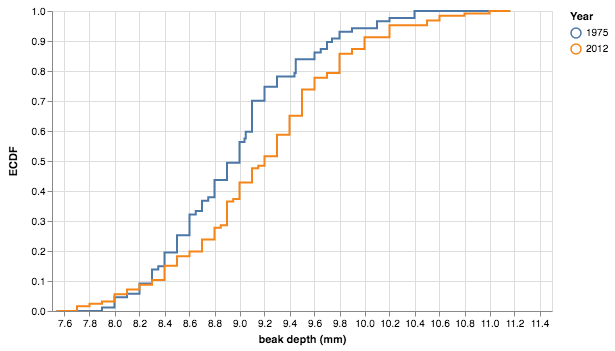

In [113]:
altcat.catplot(data=df_depths,
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x=alt.X('beak depth (mm):Q', 
                                      axis = alt.Axis(title='beak depth (mm)')),
                             color=alt.Color('year:N', title='Year')),
               transform='ecdf')


**c)** Perform a hypothesis test comparing the *G. scandens* beak depths in 1975 and 2012. Carefully state your null hypothesis, your test statistic, and your definition of what it means to be at least as extreme as the observed test statistic. Comment on the results. It might be interesting to know that a severe drought in 1976 and 1977  resulted in the death of the plants that produce small seeds on the island.

**d)** Devise a measure for the *shape* of a beak. That is, invent some scalar measure that combines both the length and depth of the beak. Compare this measure between species and through time. (This is very open-ended. It is up to you to define the measure, make relevant plots, compute confidence intervals, and possibly do hypothesis tests to see how shape changes over time and between the two species.)

**e)** Introgressive hybridization occurs when a *G. scandens* bird mates with a *G. fortis* bird, and then the offspring mates again with pure *G. scandens*. This brings traits from *G. fortis* into the *G. scandens* genome. As this may be a mode by which beak geometries of *G. scandens* change over time, it is useful to know how *heritable* a trait is. Heritability is defined as the ratio of the covariance between parents and offsprings to the *variance of the parents alone*. To be clear, the heritability is defined as follows.

1. Compute the average value of a trait in a pair of parents.
2. Compute the average value of that trait among the offspring of those parents.
3. Do this for each set of parents/offspring. Using this data set, compute the covariance between the average offspring and average parents and the variance among all average parents.
4. The heritability , $h^2$, is the ratio of the covariance between parents and offspring to the variance of the parents, $h^2 = \sigma_{po}/\sigma_p^2$.

This is a more apt definition than, say, the Pearson correlation, because it is a direct comparison between parents and offspring. 

Heritability data for beak depth for *G. fortis* and *G. scandens* can be found [here](../data/fortis_beak_depth_heredity.csv) and [here](../data/scandens_beak_depth_heredity.csv), respectively. (Be sure to look at the files before reading them in; they do have different formats.) From these data, compute the heritability of beak depth in the two species, with confidence intervals. How do they differ, and what consequences might this have for introgressive hybridization?